# Libraries

In [4]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import swifter
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/viriyanandasusilo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading the Files and Exploratory Data Analysis

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

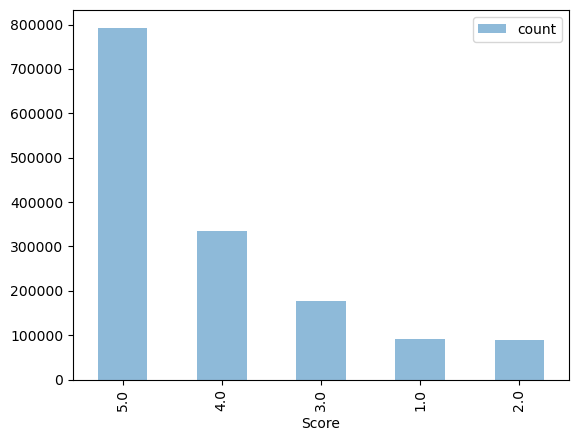


Id                             0
ProductId                      0
UserId                         0
HelpfulnessNumerator           0
HelpfulnessDenominator         0
Time                           0
Summary                       32
Text                          62
Score                     212192
dtype: int64


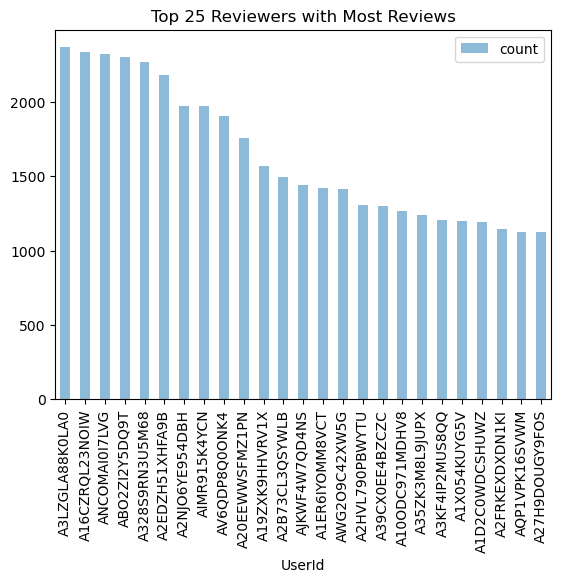

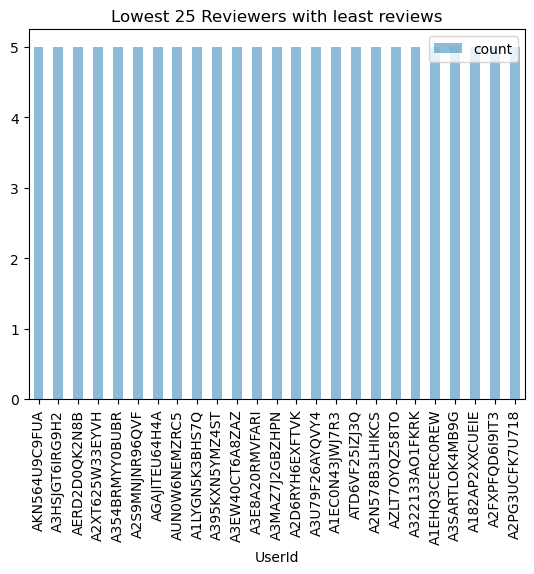

EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [5]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()

print(trainingSet.isna().sum())

trainingSet['UserId'].value_counts().nlargest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 Reviewers with Most Reviews")
plt.show()

print()

trainingSet['UserId'].value_counts().nsmallest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Lowest 25 Reviewers with least reviews")
plt.show()

print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Extracting Sample

In [9]:
trainingSet_sample = trainingSet.sample(n=100000, random_state=42)

# Cleaning Text and Combining Summary

In [10]:
# Preprocessing data

# Dropping rows where both 'Text' and 'Summary' columns are empty (NaN)
trainingSet = trainingSet.dropna(subset=['Text', 'Summary'], how='all')

# Filling missing values in 'Text' with the string 'empty' to handle NaNs
trainingSet['Text'] = trainingSet['Text'].fillna('empty')

# Filling missing values in 'Summary' with the string 'empty' to handle NaNs
trainingSet['Summary'] = trainingSet['Summary'].fillna('empty')

# Creating a new column 'Combined_Text' by concatenating 'Summary' and 'Text' with a space in between
trainingSet['Combined_Text'] = trainingSet['Summary'] + " " + trainingSet['Text']

# Repeating the same process for the 'trainingSet_sample' dataframe
# Dropping rows where both 'Text' and 'Summary' columns are empty (NaN)
trainingSet_sample = trainingSet_sample.dropna(subset=['Text', 'Summary'], how='all')

# Filling missing values in 'Text' with the string 'empty' to handle NaNs
trainingSet_sample['Text'] = trainingSet_sample['Text'].fillna('empty')

# Filling missing values in 'Summary' with the string 'empty' to handle NaNs
trainingSet_sample['Summary'] = trainingSet_sample['Summary'].fillna('empty')

# Creating a new column 'Combined_Text' by concatenating 'Summary' and 'Text' with a space in between
trainingSet_sample['Combined_Text'] = trainingSet_sample['Summary'] + " " + trainingSet_sample['Text']

# Printing the count of missing values in the 'Combined_Text' column of 'trainingSet' to verify no NaNs remain
print(trainingSet['Combined_Text'].isna().sum())


0


# Adding Features

In [45]:
# List of common negation words to use for counting occurrences in text
negation_words = ['not', 'no', 'never', 'none', "n't", 'neither', 'nor', 'without', 'hardly', 'barely', 'scarcely']

# Function for sentiment analysis using TextBlob to calculate polarity
def textblob_sentiment(text):
    return TextBlob(text).sentiment.polarity
    
def add_features_to(df):
    # Count the number of reviews for each movie (ProductId)
    df['Number_of_Reviews_for_Movie'] = df.groupby('ProductId')['ProductId'].transform('count')
    
    # Count the number of reviews made by each user (UserId)
    df['Number_of_Reviews_by_User'] = df.groupby('UserId')['UserId'].transform('count')
     
    # Get the frequency of each user
    User_Counts = df['UserId'].value_counts()
    
    # Get the total number of unique reviewers
    Total_Reviewers = len(df['UserId'].unique())
    
    # Initialize a column to label top and lowest reviewers
    df['Reviewer_top_low'] = 0 
    
    # Label the top 25 reviewers as 1
    Top_Reviewers = User_Counts.head(25).index
    df.loc[df['UserId'].isin(Top_Reviewers), 'Reviewer_top_low'] = 1

    # Label the lowest 25 reviewers as -1
    Lowest_Reviewers = User_Counts.tail(25).index
    df.loc[df['UserId'].isin(Lowest_Reviewers), 'Reviewer_top_low'] = -1

    # Get the frequency of each product
    Product_Counts = df['ProductId'].value_counts()
    
    # Get the total number of unique products
    Top_Reviewers = len(df['ProductId'].unique())

    # Initialize a column to label top and lowest reviewed products
    df['Product_top_low'] = 0

    # Label the top 25 reviewed products as 1
    Top_Reviewers = Product_Counts.head(25).index
    df.loc[df['ProductId'].isin(Top_Reviewers), 'Product_top_low'] = 1

    # Label the lowest 25 reviewed products as -1
    Lowest_Reviewers = Product_Counts.tail(25).index
    df.loc[df['ProductId'].isin(Lowest_Reviewers), 'Product_top_low'] = -1
    
    # Calculate helpfulness as a ratio of HelpfulnessNumerator to HelpfulnessDenominator
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)  # Fill NaN values with 0
    
    # Apply TextBlob sentiment analysis to get polarity scores for each review in 'Combined_Text'
    df['Sentiment'] = df['Combined_Text'].swifter.apply(lambda x: TextBlob(x).sentiment.polarity)
    
    # Calculate the length of each review in 'Text' column
    df['Review_Length'] = df['Text'].str.len()
    
    # Calculate the average helpfulness per product (ProductId) and add it to the main DataFrame
    Average_Help = df.groupby('ProductId')['Helpfulness'].mean().rename('Average_Helpfulness')
    df = df.join(Average_Help, on='ProductId')
    
    # Calculate deviation of each review's helpfulness from the product's average helpfulness
    df['Helpfulness_Deviation'] = df['Helpfulness'] - df['Average_Helpfulness']
    
    # Calculate the average deviation of helpfulness per user, representing how each user's helpfulness differs from the product's average
    df['User_Deviation'] = df.groupby('UserId')['Helpfulness_Deviation'].transform('mean').rename('UserAverageDeviation')
    
    # Calculate average sentiment for each product (ProductId) and add deviation from product average sentiment
    Product_Average_Sentiment = df.groupby('ProductId')['Sentiment'].transform('mean')
    df['Sentiment_Deviation'] = df['Sentiment'] - Product_Average_Sentiment
    
    # Count the number of exclamation marks, question marks, and capital letters in each review
    df['Exclamation_Count'] = df['Combined_Text'].str.count('!')
    df['Question_Count'] = df['Combined_Text'].str.count(r'\?')
    df['Capital_Letter_Count'] = df['Combined_Text'].apply(lambda x: sum(1 for char in x if char.isupper()))
    
    # Count the number of negation words in each review
    df['Negation_Count'] = df['Combined_Text'].apply(lambda x: sum(1 for word in x.split() if word.lower() in negation_words))

    # Calculate average exclamation, question, and negation counts per product and their deviation from product averages
    Product_Average_Exclamation = df.groupby('ProductId')['Exclamation_Count'].transform('mean')
    Product_Average_Question = df.groupby('ProductId')['Question_Count'].transform('mean')
    Product_Average_Negation = df.groupby('ProductId')['Negation_Count'].transform('mean')
    df['Exclamation_Count_Deviation'] = df['Exclamation_Count'] - Product_Average_Exclamation
    df['Question_Count_Deviation'] = df['Question_Count'] - Product_Average_Question
    df['Negation_Count_Deviation'] = df['Negation_Count'] - Product_Average_Negation

    # TF-IDF Vectorization of 'Combined_Text' with maximum 1000 features and bigrams
    tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['Combined_Text'])
    
    # Convert the TF-IDF matrix to a DataFrame with appropriate column names
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])])
    tfidf_df.index = df.index  # Align indices with the original DataFrame
    
    # Concatenate the TF-IDF features with the original DataFrame
    df = pd.concat([df, tfidf_df], axis=1)
    
    return df


# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    
    # Dropping Features that is not Needed
    train.drop("Average_Helpfulness", axis=1, inplace=True)
    train.drop("Helpfulness_Deviation", axis=1, inplace=True)
    train.drop("Text", axis=1, inplace=True)
    train.drop("Summary", axis=1, inplace=True)
    train.drop("Combined_Text", axis=1, inplace=True)
    
    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x']) 
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    X_train =  train[train['Score'].notnull()]
    y_train = X_train['Score']
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

Pandas Apply:   0%|          | 0/1697533 [00:00<?, ?it/s]

# Sample + Split into training and testing set

In [46]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    y_train,
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [47]:
# From the features of X 
features = ['User_Deviation','Helpfulness','Sentiment','HelpfulnessNumerator','HelpfulnessDenominator','Time',
            'Number_of_Reviews_for_Movie','Number_of_Reviews_by_User','Review_Length','Reviewer_top_low',
            'Product_top_low','Sentiment_Deviation','Exclamation_Count','Question_Count','Negation_Count',
            'Capital_Letter_Count','Exclamation_Count_Deviation','Question_Count_Deviation','Negation_Count_Deviation']

# Selecting TF-IDF columns
tfidf=[col for col in X_train.columns if "tfidf" in col]

# Combine both original features and TF-IDF features
selected_features = features+ tfidf

#Inserting features on to 
X_train_select = X_train[selected_features]
X_test_select = X_test[selected_features]
X_submission_select = X_submission[selected_features]

# Model Creation and Running Using Hist Gradient Boosting Classifier

In [74]:
# Creating the Model and Running Using Hist Gradient Boosting Classifier
# Ran GridSearchCV for hyperparameter tuning on previous runs and found
# The specifications below to produce the most accurate reusult
from sklearn.ensemble import HistGradientBoostingClassifier 
best_hg_model = HistGradientBoostingClassifier(
    max_iter=1000,
    learning_rate=0.05,
    max_leaf_nodes=80,
    min_samples_leaf=40,
    random_state=42
)
# Fitting the model
best_hg_model.fit(X_train_select, Y_train)

# Making predictions
best_hg_preds = best_hg_model.predict(X_test_select)

In [75]:
print("HG Accuracy:", accuracy_score(Y_test,best_hg_preds))

HG Accuracy: 0.6600841286597583


# Model Evaluation

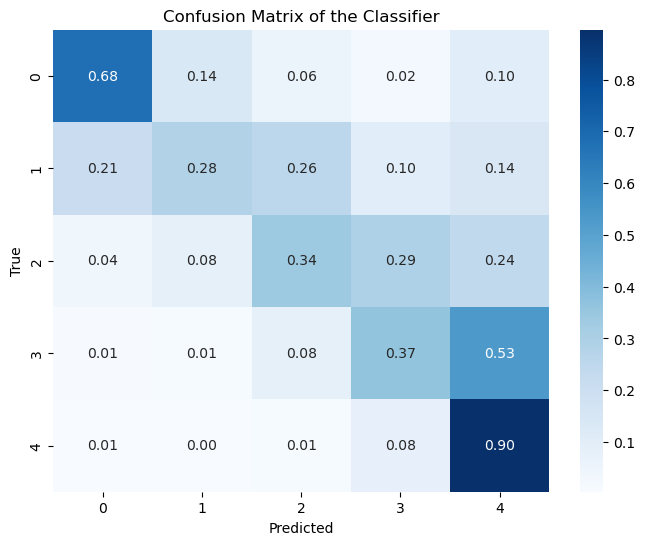

In [76]:
# Confusion Matrix
cm = confusion_matrix(Y_test, best_hg_preds, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".2f")
plt.title('Confusion Matrix of the Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [283]:
# Create the submission file
X_submission['Score'] = best_hg_model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
print(submission.shape)
submission.to_csv("./data/submission.csv", index=False)

(212192, 2)
